https://www.kaggle.com/nitinsurya/surprise-me-2-neural-networks-keras

In [1]:
from __future__ import division

In [2]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st
tunguz - Surprise Me 2!
https://www.kaggle.com/tunguz/surprise-me-2/code
aharless - Exclude same wk res from Nitin's SurpriseMe2 w NN
https://www.kaggle.com/aharless/exclude-same-wk-res-from-nitin-s-surpriseme2-w-nn/versions#base=2217075&new=2253052
Pranav Pandya - Surprise me! H2O autoML version
https://www.kaggle.com/pranav84/surprise-me-h2o-automl-version

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

from keras.layers import Embedding, Input, Dense
from keras.models import Model
import keras
import keras.backend as K

import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML
h2o.init()

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpWWgtSK
  JVM stdout: /tmp/tmpWWgtSK/h2o_bo_started_from_python.out
  JVM stderr: /tmp/tmpWWgtSK/h2o_bo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster version:        3.16.0.2
H2O cluster version age:    2 months and 1 day
H2O cluster name:           H2O_from_python_bo_39cqgh
H2O cluster total nodes:    1
H2O cluster free memory:    20.98 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             2.7.14 final
--------------------------  ----------------------------------------

In [3]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

def plot_actual_predicted(actual, predicted):
    print('RMSE: ', RMSLE(actual, predicted))
    tmp = pd.DataFrame({'actual': actual, 'predicted': predicted}).sort_values(['actual'])
    plt.scatter(range(tmp.shape[0]), tmp['predicted'], color='green')
    plt.scatter(range(tmp.shape[0]), tmp['actual'], color='blue')
    plt.show()
    del tmp

In [4]:
data = {
    'tra': pd.read_csv('../input/air_visit_data.csv'),
    'as': pd.read_csv('../input/air_store_info.csv'),
    'hs': pd.read_csv('../input/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/air_reserve.csv'),
    'hr': pd.read_csv('../input/hpg_reserve.csv'),
    'id': pd.read_csv('../input/store_id_relation.csv'),
    'tes': pd.read_csv('../input/sample_submission.csv'),
    'hol': pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [5]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_dow'] = data[df]['visit_datetime'].dt.dayofweek
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # NEW FEATURE FROM aharless kernel
    # Exclude less than 2 days gap
    data[df] = data[df][data[df]['reserve_datetime_diff'] > 2]
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [6]:




data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
# NEW FEATURE FROM aharless kernel
data['tra']['week'] = data['tra']['visit_date'].dt.week
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['week'] = data['tes']['visit_date'].dt.week
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

train['visitors'] = np.log1p(train['visitors'].values)

In [7]:
value_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

nn_col = value_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']


X = train.copy()
X_test = test[nn_col].copy()

value_scaler = preprocessing.MinMaxScaler()
for vcol in value_col:
    X[vcol] = value_scaler.fit_transform(X[vcol].values.astype(np.float64).reshape(-1, 1))
    X_test[vcol] = value_scaler.transform(X_test[vcol].values.astype(np.float64).reshape(-1, 1))

X_train = list(X[nn_col].T.as_matrix())
Y_train = X['visitors'].values
nn_train = [X_train, Y_train]
nn_test = [list(X_test[nn_col].T.as_matrix())]
print("Train and test data prepared for NN")

htrain = h2o.H2OFrame(train)
htest = h2o.H2OFrame(test)

htrain.drop(['id', 'air_store_id', 'visit_date'])
htest.drop(['id', 'air_store_id', 'visit_date'])

htrain_x=htrain.columns
htrain_y='visitors'
htrain_x.remove(htrain_y)
print("Train and test data prepared for AutoML")

Train and test data prepared for NN
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Train and test data prepared for AutoML


In [8]:
def get_nn_complete_model(train, hidden1_neurons=35, hidden2_neurons=15):
    """
    Input:
        train:           train dataframe(used to define the input size of the embedding layer)
        hidden1_neurons: number of neurons in the first hidden layer
        hidden2_neurons: number of neurons in the first hidden layer
    Output:
        return 'keras neural network model'
    """
    K.clear_session()

    air_store_id = Input(shape=(1,), dtype='int32', name='air_store_id')
    air_store_id_emb = Embedding(len(train['air_store_id2'].unique()) + 1, 15, input_shape=(1,),
                                 name='air_store_id_emb')(air_store_id)
    air_store_id_emb = keras.layers.Flatten(name='air_store_id_emb_flatten')(air_store_id_emb)

    dow = Input(shape=(1,), dtype='int32', name='dow')
    dow_emb = Embedding(8, 3, input_shape=(1,), name='dow_emb')(dow)
    dow_emb = keras.layers.Flatten(name='dow_emb_flatten')(dow_emb)

    month = Input(shape=(1,), dtype='int32', name='month')
    month_emb = Embedding(13, 3, input_shape=(1,), name='month_emb')(month)
    month_emb = keras.layers.Flatten(name='month_emb_flatten')(month_emb)

    air_area_name, air_genre_name = [], []
    air_area_name_emb, air_genre_name_emb = [], []
    for i in range(7):
        area_name_col = 'air_area_name' + str(i)
        air_area_name.append(Input(shape=(1,), dtype='int32', name=area_name_col))
        tmp = Embedding(len(train[area_name_col].unique()), 3, input_shape=(1,),
                        name=area_name_col + '_emb')(air_area_name[-1])
        tmp = keras.layers.Flatten(name=area_name_col + '_emb_flatten')(tmp)
        air_area_name_emb.append(tmp)

        if i > 4:
            continue
        area_genre_col = 'air_genre_name' + str(i)
        air_genre_name.append(Input(shape=(1,), dtype='int32', name=area_genre_col))
        tmp = Embedding(len(train[area_genre_col].unique()), 3, input_shape=(1,),
                        name=area_genre_col + '_emb')(air_genre_name[-1])
        tmp = keras.layers.Flatten(name=area_genre_col + '_emb_flatten')(tmp)
        air_genre_name_emb.append(tmp)

    air_genre_name_emb = keras.layers.concatenate(air_genre_name_emb)
    air_genre_name_emb = Dense(4, activation='sigmoid', name='final_air_genre_emb')(air_genre_name_emb)

    air_area_name_emb = keras.layers.concatenate(air_area_name_emb)
    air_area_name_emb = Dense(4, activation='sigmoid', name='final_air_area_emb')(air_area_name_emb)
    
    air_area_code = Input(shape=(1,), dtype='int32', name='air_area_code')
    air_area_code_emb = Embedding(len(train['air_area_name'].unique()), 8, input_shape=(1,), name='air_area_code_emb')(air_area_code)
    air_area_code_emb = keras.layers.Flatten(name='air_area_code_emb_flatten')(air_area_code_emb)
    
    air_genre_code = Input(shape=(1,), dtype='int32', name='air_genre_code')
    air_genre_code_emb = Embedding(len(train['air_genre_name'].unique()), 5, input_shape=(1,),
                                   name='air_genre_code_emb')(air_genre_code)
    air_genre_code_emb = keras.layers.Flatten(name='air_genre_code_emb_flatten')(air_genre_code_emb)

    
    holiday_flg = Input(shape=(1,), dtype='float32', name='holiday_flg')
    year = Input(shape=(1,), dtype='float32', name='year')
    min_visitors = Input(shape=(1,), dtype='float32', name='min_visitors')
    mean_visitors = Input(shape=(1,), dtype='float32', name='mean_visitors')
    median_visitors = Input(shape=(1,), dtype='float32', name='median_visitors')
    max_visitors = Input(shape=(1,), dtype='float32', name='max_visitors')
    count_observations = Input(shape=(1,), dtype='float32', name='count_observations')
    rs1_x = Input(shape=(1,), dtype='float32', name='rs1_x')
    rv1_x = Input(shape=(1,), dtype='float32', name='rv1_x')
    rs2_x = Input(shape=(1,), dtype='float32', name='rs2_x')
    rv2_x = Input(shape=(1,), dtype='float32', name='rv2_x')
    rs1_y = Input(shape=(1,), dtype='float32', name='rs1_y')
    rv1_y = Input(shape=(1,), dtype='float32', name='rv1_y')
    rs2_y = Input(shape=(1,), dtype='float32', name='rs2_y')
    rv2_y = Input(shape=(1,), dtype='float32', name='rv2_y')
    total_reserv_sum = Input(shape=(1,), dtype='float32', name='total_reserv_sum')
    total_reserv_mean = Input(shape=(1,), dtype='float32', name='total_reserv_mean')
    total_reserv_dt_diff_mean = Input(shape=(1,), dtype='float32', name='total_reserv_dt_diff_mean')
    date_int = Input(shape=(1,), dtype='float32', name='date_int')
    var_max_lat = Input(shape=(1,), dtype='float32', name='var_max_lat')
    var_max_long = Input(shape=(1,), dtype='float32', name='var_max_long')
    lon_plus_lat = Input(shape=(1,), dtype='float32', name='lon_plus_lat')

    date_emb = keras.layers.concatenate([dow_emb, month_emb, year, holiday_flg])
    date_emb = Dense(5, activation='sigmoid', name='date_merged_emb')(date_emb)

    cat_layer = keras.layers.concatenate([holiday_flg, min_visitors, mean_visitors,
                    median_visitors, max_visitors, count_observations, rs1_x, rv1_x,
                    rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y,
                    total_reserv_sum, total_reserv_mean, total_reserv_dt_diff_mean,
                    date_int, var_max_lat, var_max_long, lon_plus_lat,
                    date_emb, air_area_name_emb, air_genre_name_emb,
                    air_area_code_emb, air_genre_code_emb, air_store_id_emb])

    m = Dense(hidden1_neurons, name='hidden1',
             kernel_initializer=keras.initializers.RandomNormal(mean=0.0,
                            stddev=0.05, seed=None))(cat_layer)
    m = keras.layers.LeakyReLU(alpha=0.2)(m)
    m = keras.layers.BatchNormalization()(m)
    
    m1 = Dense(hidden2_neurons, name='hidden2')(m)
    m1 = keras.layers.LeakyReLU(alpha=0.2)(m1)
    m = Dense(1, activation='relu')(m1)

    inp_ten = [
        holiday_flg, min_visitors, mean_visitors, median_visitors, max_visitors, count_observations,
        rs1_x, rv1_x, rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y, total_reserv_sum, total_reserv_mean,
        total_reserv_dt_diff_mean, date_int, var_max_lat, var_max_long, lon_plus_lat,
        dow, year, month, air_store_id, air_area_code, air_genre_code
    ]
    inp_ten += air_area_name
    inp_ten += air_genre_name
    model = Model(inp_ten, m)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

    return model

In [10]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3,
                    n_estimators=200, subsample=0.8, max_depth =10)
# model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
# model2 = ensemble.RandomForestRegressor(n_estimators=13, random_state=3, max_depth=18,
#                                         min_weight_fraction_leaf=0.0002)
model2 = H2OAutoML(max_runtime_secs=1200)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=300, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =10)
model4 = get_nn_complete_model(train, hidden2_neurons=12)

model1.fit(train[col], train['visitors'].values)
print("Model1 trained")

model2.train(x=htrain_x, y=htrain_y, training_frame=htrain, leaderboard_frame=htest)
htrain.drop(['visitors'])
print("Model2 trained")

model3.fit(train[col], train['visitors'].values)
print("Model3 trained")


Model1 trained
AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Model2 trained
Model3 trained


Model4 trained
drf prediction progress: |████████████████████████████████████████████████| 100%
GradientBoostingRegressor:
('RMSE: ', 0.34769472073305707)


AutoML:
('RMSE: ', 0.37945865753689206)


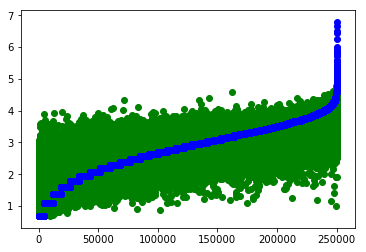

XGBRegressor:
('RMSE: ', 0.36234205107950035)


NeuralNetwork:
('RMSE: ', 0.49163354296521766)


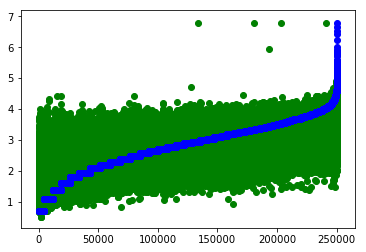

drf prediction progress: |████████████████████████████████████████████████| 100%
Model predictions done.


In [11]:

model4.fit(nn_train[0], nn_train[1], epochs=12, verbose=0, batch_size=512, shuffle=True)
model4.fit(nn_train[0], nn_train[1], epochs=3, verbose=0, batch_size=512, shuffle=True,
           validation_split=0.15)
model4.fit(nn_train[0], nn_train[1], epochs=10, verbose=0, batch_size=512, shuffle=True)
print("Model4 trained")

preds1 = model1.predict(train[col])
preds2 = model2.leader.predict(htrain).as_data_frame().clip(0, 6.8).values.reshape(-1)
preds3 = model3.predict(train[col])
preds4 = pd.Series(model4.predict(nn_train[0]).reshape(-1)).clip(0, 6.8).values

actual_output = train['visitors'].values
print('GradientBoostingRegressor:')
plot_actual_predicted(actual_output, preds1)
print('AutoML:')
plot_actual_predicted(actual_output, preds2)
print('XGBRegressor:')
plot_actual_predicted(actual_output, preds3)
print('NeuralNetwork:')
plot_actual_predicted(actual_output, preds4)

preds1 = model1.predict(test[col])
preds2 = model2.leader.predict(htest).as_data_frame().clip(0, 6.8).values.reshape(-1)
preds3 = model3.predict(test[col])
# .clip(0, 6.8) used to avoid random high values that might occur
preds4 = pd.Series(model4.predict(nn_test[0]).reshape(-1)).clip(0, 6.8).values

test['visitors'] = 0.2*preds1+0.2*preds2+0.3*preds3+0.3*preds4
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
sub1['preds1'] = pd.Series(preds1)
sub1['preds2'] = pd.Series(preds2)
sub1['preds3'] = pd.Series(preds3)
sub1['preds4'] = pd.Series(preds4)
print("Model predictions done.")
# del train; del data;

In [12]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../input/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub2 = sub2.fillna(-1) # for the unfound values

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [13]:
def final_visitors(x, alt=False):
    visitors_x, visitors_y = x['visitors_x'], x['visitors_y']
    if x['visitors_y'] == -1:
        return visitors_x
    else:
        return 0.7*visitors_x + 0.3*visitors_y* 1.1

sub_merge = pd.merge(sub1, sub2, on='id', how='inner')
sub_merge['visitors'] = sub_merge.apply(lambda x: final_visitors(x), axis=1)
print("Done")
sub_merge[['id', 'visitors']].to_csv('../submission/kk_surprise-me-2-neural-networks-keras.csv.gz', 
                                     index=False,compression='gzip')

Done
